# Learnable Moran's Index
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/L-DSilva/LearnableMoransIndex/blob/main/morans_surv_full.ipynb)

Full run for predicting DSS outcomes using learnable spatial autocorrelation (Moran's Index).
Dataset is available in the public [Google Drive](https://drive.google.com/file/d/1cBDVwrMdWskTCf2E_kMv3wZEeoIptUWa/view?usp=drive_link).


Dataset size: 523

--- Fold 0 ---
Train: 313, Val: 105, Test: 105
Iter 0 | Loss: 0.9993 | Val C-Index: 0.3799
Iter 1 | Loss: 1.0225 | Val C-Index: 0.3423
Iter 2 | Loss: 0.9524 | Val C-Index: 0.3244
Iter 3 | Loss: 0.9935 | Val C-Index: 0.3154
Iter 4 | Loss: 0.9912 | Val C-Index: 0.2993
Iter 5 | Loss: 0.9785 | Val C-Index: 0.2993
Iter 6 | Loss: 0.9426 | Val C-Index: 0.2975
Iter 7 | Loss: 0.9813 | Val C-Index: 0.3100
Iter 8 | Loss: 1.0425 | Val C-Index: 0.3226
Iter 9 | Loss: 1.0053 | Val C-Index: 0.3441
Iter 10 | Loss: 0.9883 | Val C-Index: 0.3513
Iter 11 | Loss: 1.1170 | Val C-Index: 0.4050
Iter 12 | Loss: 1.0476 | Val C-Index: 0.3871
Iter 13 | Loss: 0.9578 | Val C-Index: 0.3656
Iter 14 | Loss: 0.9705 | Val C-Index: 0.3728
Iter 15 | Loss: 0.9980 | Val C-Index: 0.3817
Iter 16 | Loss: 0.9311 | Val C-Index: 0.3781
Iter 17 | Loss: 0.9728 | Val C-Index: 0.3943
Iter 18 | Loss: 0.7664 | Val C-Index: 0.3961
Iter 19 | Loss: 0.9623 | Val C-Index: 0.3943
Iter 20 | Loss: 1.1165 | Val C-Index: 0.3961

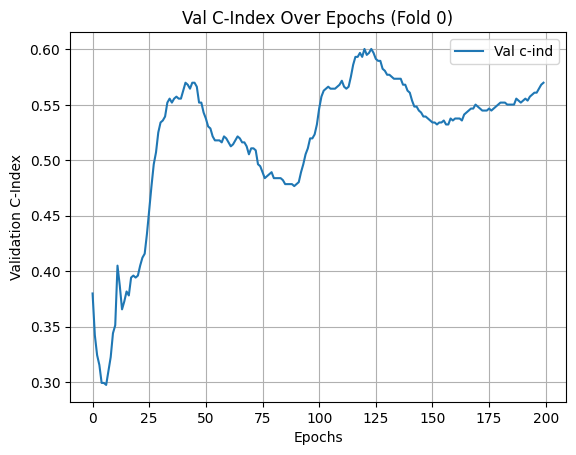

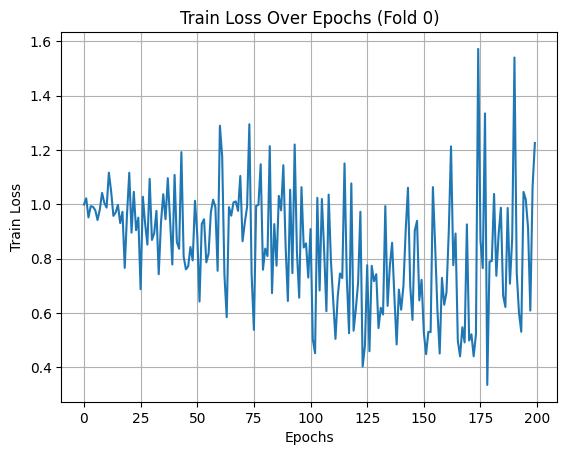

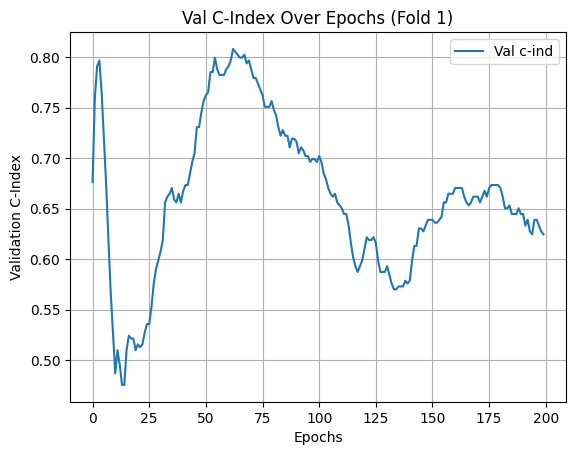

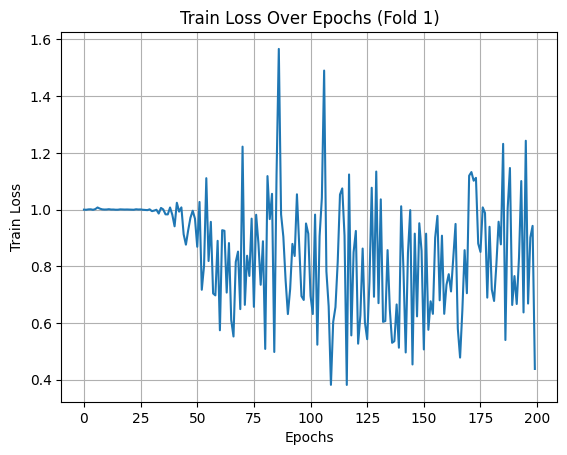

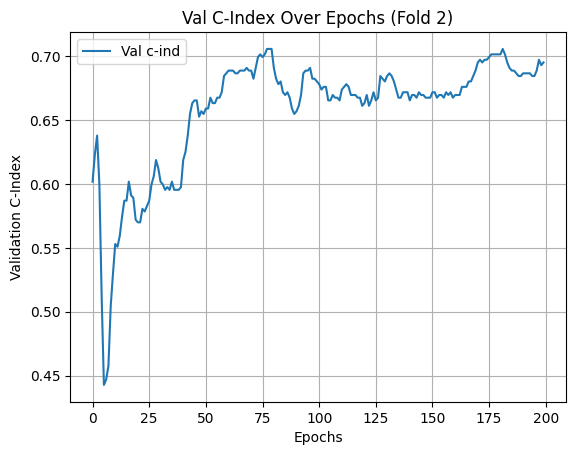

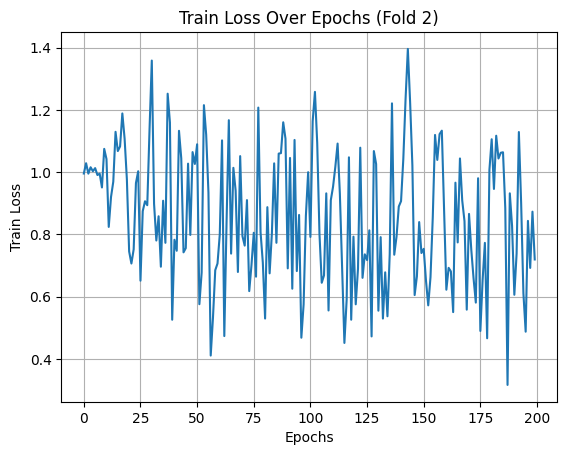

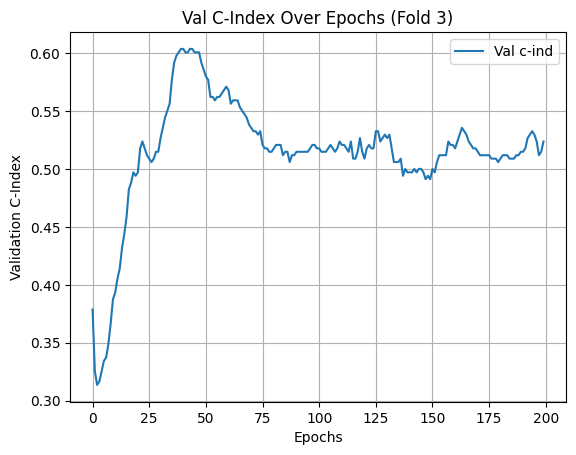

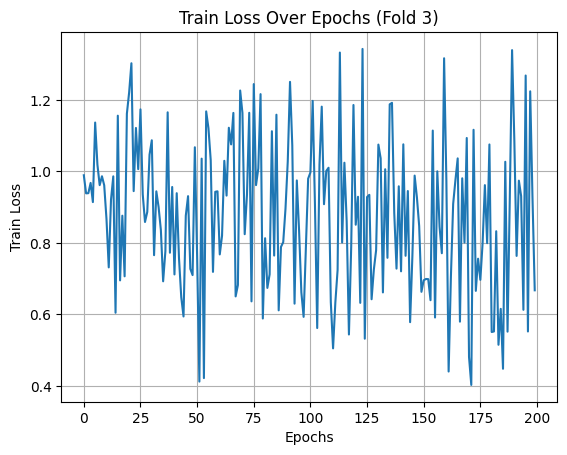

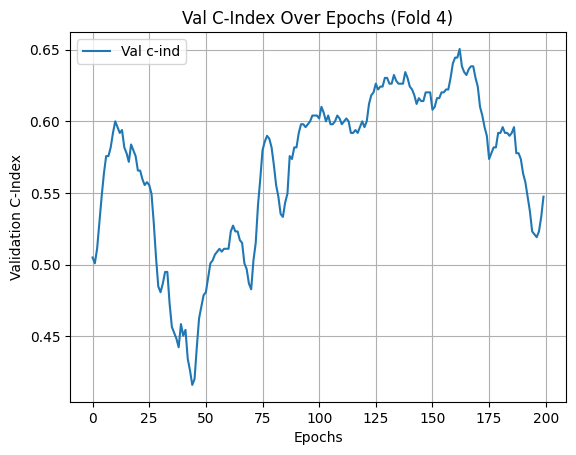

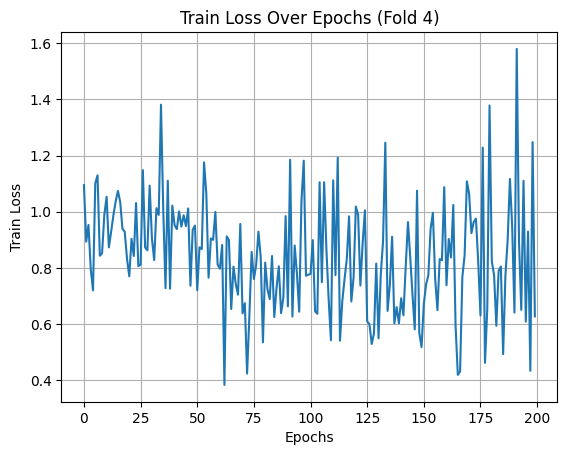

In [ ]:
!pip install -U gdown
!pip install torch_geometric
!pip install lifelines

import torch
import torch.nn as nn
import numpy as np
import pickle
import time
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from lifelines.utils import concordance_index

# === CONFIGURATION === #
dataset_file_link = 'https://drive.google.com/uc?id=1cBDVwrMdWskTCf2E_kMv3wZEeoIptUWa'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 0
num_epochs = 200  # ~1.33 epochs (exposures to entire train set)
lr = 0.001


# === MODEL DEFINITION === #

class LearnableMoransIndex(torch.nn.Module):
  def __init__(self, input_dim):
    """
    Initialise Learnable Moran's Index model, with adaptive_theta, preprocess (feature-mapping) and postprocess (output mapping) neural blocks.

    Args:
      input_dim: input dimension of node feature matrix (number of features per node)
    """
    super(LearnableMoransIndex, self).__init__()

    self.adaptive_theta = torch.nn.Sequential(
      torch.nn.Linear(input_dim, 1),
    )

    self.preprocess = torch.nn.Sequential(
      torch.nn.Linear(input_dim, 1),
      torch.nn.Tanh(),
      torch.nn.Linear(1, 1),
      torch.nn.Tanh(),
      torch.nn.Linear(1, 1)
    )

    self.postprocess = torch.nn.Sequential(
      torch.nn.Tanh()
    )

  def get_weight_matrix(self, coords, adaptive_theta):
    """
    Generate and return weight matrix for computation of Moran's Index.
    Compute weights as wij = e^-theta(euclidean distance between ith and jth nodes).
    Euclidean distance is d = sqrt{(xi - xj)^2 + (yi - yj)^2}

    Args:
      coords: spatial coordinates of nodes (shape N x 2)
      adaptive_theta: computed per-node adaptive decay spread coefficient (shape N x 1)

    Returns:
      weights_row_stochastic: computed edge weights using Gaussian exponential decay (shape N x N)
    """
    coords_diff = coords[:, None, :] - coords # compute difference in coords using broadcasting, shape N x N x 2
    # Compute pairwise euclidean distances
    distances = torch.sqrt(torch.sum(coords_diff ** 2, dim=-1))
    weights = torch.exp(-(adaptive_theta**2) * distances)
    # make weight matrix row-stochastic
    weights_row_sum = torch.sum(weights, dim=1).unsqueeze(1)
    weights_row_stochastic = weights / weights_row_sum
    return weights_row_stochastic


  def compute_morans_i(self, weights, features):
    """
    Compute Moran's Index from weight matrix and mapped features

    Args:
      weights: edge weight matrix (shape N x N)
      features: mapped 1-dimensional features per node (shape N x 1)

    Returns:
      morans_i.unsqueeze(0): computed moran's i value (shape 1 x 1)
    """
    mu_feat = torch.mean(features)
    feat_mean_norm = features - mu_feat
    feat_mean_norm_outer_prod = torch.outer(feat_mean_norm, feat_mean_norm) # (xi - ux)(xj - ux), N x N
    weighted_prod = weights * feat_mean_norm_outer_prod   # wij * (xi - ux)(xj - ux), N x N (element-wise)
    morans_nr = torch.sum(weighted_prod)  # numerator (unscaled)
    morans_dr = torch.mean(feat_mean_norm**2) + 1e-7  # denominator: variance of centred features
    morans_i = morans_nr / (torch.sum(weights) * (morans_dr))
    return morans_i.unsqueeze(0)

  def forward(self, graph):
    """
    Computes model output score for input graph object.

    Args:
      graph (object):
                A graph object containing:
                    - `x`: Node features (shape N x d)
                    - `coords`: Node coordinates (shape N x c)

    Returns:
      out: Model output score (shape 1 x 1)
    """
    features = graph.x
    coords = graph.coords
    adaptive_theta = self.adaptive_theta(features)
    w = self.get_weight_matrix(coords, adaptive_theta)
    processed_features = self.preprocess(features).squeeze(1)
    morans_i = self.compute_morans_i(w, processed_features)
    out = self.postprocess(morans_i)
    return out


# === LOAD DATA === #
def get_dataset():
    """
    Download dataset from public gdrive file link

    Returns:
      df['ShuffleNet_graph']: graphs representations of WSIs
      df['DSS_cr']: DSS event indicators
      df['DSS_time_cr']: DSS times (in days)
      list(df.index): list of indices for dataset dataframe
    """
    gdown.download(dataset_file_link, 'dataset.pkl', quiet=False)
    with open('dataset.pkl', 'rb') as file:
        df = pickle.load(file)
    return df['ShuffleNet_graph'], df['DSS_cr'], df['DSS_time_cr'], list(df.index)

graphs, dss_event, dss_time, patient_ids = get_dataset()
print(f'Dataset size: {len(graphs)}')

# === METRIC TRACKING === #
train_c_index = []
val_c_index = []
test_c_index = []
test_sets = {}
start_time = time.time()

# === CROSS-VALIDATION === #
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

for k_num, (train_val_index, test_index) in enumerate(skf.split(graphs, dss_event, groups=patient_ids)):
    print(f"\n--- Fold {k_num} ---")

    # Split data
    x_train_val, x_test = graphs.iloc[train_val_index], graphs.iloc[test_index]
    dss_event_train_val, dss_event_test = dss_event.iloc[train_val_index], dss_event.iloc[test_index]
    dss_time_train_val, dss_time_test = dss_time.iloc[train_val_index], dss_time.iloc[test_index]
    patient_ids_train_val = [patient_ids[i] for i in train_val_index]
    test_sets[k_num] = test_index

    # Split train/val
    skf2 = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=SEED)
    train_index, val_index = next(skf2.split(x_train_val, dss_event_train_val, groups=patient_ids_train_val))
    x_train, x_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index]
    dss_event_train, dss_event_val = dss_event_train_val.iloc[train_index], dss_event_train_val.iloc[val_index]
    dss_time_train, dss_time_val = dss_time_train_val.iloc[train_index], dss_time_train_val.iloc[val_index]

    print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

    # Model setup
    torch.manual_seed(SEED + k_num)
    np.random.seed(SEED + k_num)
    model = LearnableMoransIndex(input_dim=1024).to(device)
    optimiser = torch.optim.AdamW(model.parameters(), lr=lr)

    # Prepare training indices for DSS event = 1 samples
    occurred_idxs = [i for i, e in enumerate(dss_event_train) if e == 1]

    # Validation setup
    best_c_index = 0
    best_epoch = 0
    val_c_indices = []
    train_c_indices = []
    train_loss = []

    # Model training
    for epoch in range(num_epochs):
        model.train()
        optimiser.zero_grad()

        # Pick samples for ranking loss
        while True:
            i1 = np.random.choice(len(dss_time_train))
            i2 = np.random.choice(occurred_idxs)
            if dss_time_train.iloc[i2] < dss_time_train.iloc[i1]:
                break

        high_surv = x_train.iloc[i1].to(device)
        low_surv = x_train.iloc[i2].to(device)
        s1 = model(high_surv)
        s2 = model(low_surv)
        loss = torch.clamp(1 - (s1 - s2), min=0)  # Ranking loss
        loss.backward()
        optimiser.step()

        # Validation
        model.eval()
        val_preds = []
        train_preds = []
        with torch.no_grad():
            for g in x_val:
                val_preds.append(model(g.to(device)).cpu())
            for g in x_train:
                train_preds.append(model(g.to(device)).cpu())
        val_c = concordance_index(dss_time_val, val_preds, dss_event_val)
        val_c_indices.append(val_c)
        train_c_indices.append(concordance_index(dss_time_train, train_preds, dss_event_train))
        train_loss.append(loss.item())
        print(f"Iter {epoch} | Loss: {loss.item():.4f} | Val C-Index: {val_c:.4f}")

        if val_c > best_c_index:
            best_c_index = val_c
            best_epoch = epoch
            torch.save(model.state_dict(), f"morans_survival_fold_{k_num}.pth")

    # Plot C-index
    plt.figure()
    plt.plot(val_c_indices, label='Val c-ind')
    plt.plot(train_c_indices, label='Train c-ind')
    plt.xlabel("Epochs")
    plt.ylabel("Validation C-Index")
    plt.title(f"Val C-Index Over Epochs (Fold {k_num})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"morans_val_cindex_fold_{k_num}.png")

    # Plot loss
    plt.figure()
    plt.plot(train_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss")
    plt.title(f"Train Loss Over Epochs (Fold {k_num})")
    plt.grid(True)
    plt.savefig(f"morans_train_loss_fold_{k_num}.png")

    print("Best val c-index obtained at epoch: ", best_epoch)

    # Load best model and evaluate
    model.load_state_dict(torch.load(f"morans_survival_fold_{k_num}.pth"), strict=False)
    model.eval()

    def evaluate(x_set, time_set, event_set):
        """
        Evaluate c-index for given dataset.

        Args:
          x_set: dataset graphs
          time_set: dataset DSS times
          event_set: dataset DSS event indicators

        Returns:
          concordance_index(time_set, preds, event_set): calculated c-index for model performance on the given dataset
        """
        preds = []
        with torch.no_grad():
            for g in x_set:
                preds.append(model(g.to(device)).cpu())
        return concordance_index(time_set, preds, event_set)

    print("Evaluating best model...")
    train_c_i = evaluate(x_train, dss_time_train, dss_event_train)
    val_c_i = evaluate(x_val, dss_time_val, dss_event_val)
    test_c_i = evaluate(x_test, dss_time_test, dss_event_test)
    train_c_index.append(train_c_i)
    val_c_index.append(val_c_i)
    test_c_index.append(test_c_i)
    print(f"Train C-Index:      {train_c_i}")
    print(f"Validation C-Index: {val_c_i}")
    print(f"Test C-Index:       {test_c_i}")


# === Final Report === #
end_time = time.time()
# Store test sets for visualisations
with open("test_sets_trainvaltest_tcga.pkl", "wb") as f:
    pickle.dump(test_sets, f)

print("\n======= FINAL RESULTS =======")
print(f"Train C-Index:      {np.mean(train_c_index):.3f} ± {np.std(train_c_index):.3f}")
print(f"Validation C-Index: {np.mean(val_c_index):.3f} ± {np.std(val_c_index):.3f}")
print(f"Test C-Index:       {np.mean(test_c_index):.3f} ± {np.std(test_c_index):.3f}")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print("==============================")